# EXERCISE 4 - Climate evolution on the geological time scale

In [3]:
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import numba
import time
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LogisticRegression

Loading data:

In [4]:
data = np.loadtxt("airT_dec5.dat")
data.shape

(21578, 96)

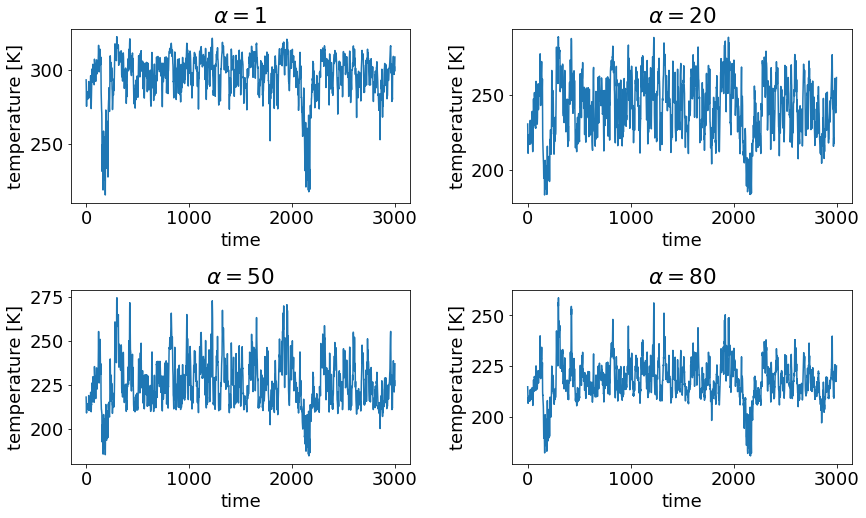

In [7]:
plt.rcParams['font.size'] = 18
sample_variables = np.array([[1,20],[50,80]])
fig, ax = plt.subplots(2,2,figsize=(14,8))
for i in range(sample_variables.shape[0]):
    for j in range(sample_variables.shape[1]):
        var = sample_variables[i,j]
        ax[i,j].plot(data[:3000,var])
        ax[i,j].set_title("$\\alpha=$" + str(var))
        ax[i,j].set_xlabel("time")
        ax[i,j].set_ylabel("temperature [K]")
fig.subplots_adjust(hspace=.5,wspace=.3)
plt.show()

## 0) Preliminary dimensional reduction using PCA
Preprocessing data in order to apply PCA:

In [8]:
data_std = (data - np.mean(data,axis=0)) / np.std(data,axis=0)

Computing and diagonalizing covariance matrix:
\begin{equation}
    C_{\alpha\beta} = \frac{1}{N}\sum_{i=1}^N X_{\alpha}^i\,X_{\beta}^i\,.
\end{equation}

In [9]:
N = data_std.shape[0] # 21578
D = data_std.shape[1] # 96
covariance_X = np.zeros((D,D))
for D1 in range(D):
    for D2 in range(D):
        covariance_X[D1,D2] = np.sum(data_std[:,D1]*data_std[:,D2]) / N

In [10]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_X) # optimized for symmetric real matrices
eigenvalues = np.flip(eigenvalues)  # by default in ascending order
eigenvectors = np.flip(eigenvectors,axis=1)

Plotting the spectrum $\lambda_k$ of $\mathbf{C}$ and the quality factor
\begin{equation}
    q_k = \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^N\lambda_i}\,.
\end{equation}

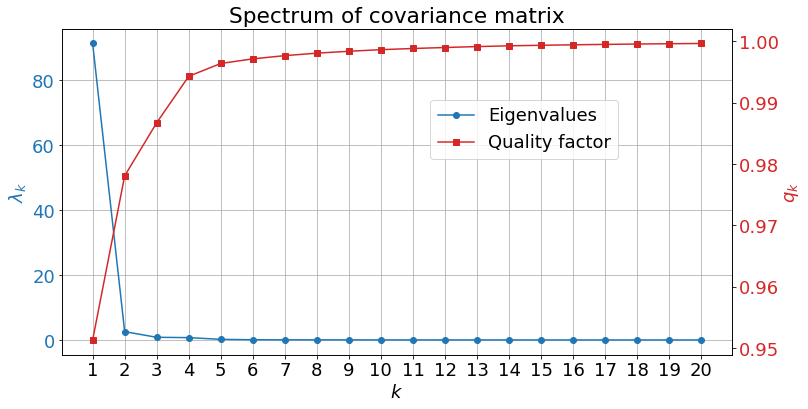

In [19]:
fig, ax1 = plt.subplots(figsize=(12,6))

k_max = 20
color = 'tab:blue'
lns1 = ax1.plot(np.arange(1,k_max+1),eigenvalues[:k_max],'o-',color=color,label="Eigenvalues")
ax1.set(xlabel="$k$",title="Spectrum of covariance matrix")
ax1.set_ylabel(ylabel="$\\lambda_k$",color=color)
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,k_max+1),np.cumsum(eigenvalues[:k_max])/np.sum(eigenvalues),'s-',color=color,label="Quality factor")
ax2.set_ylabel("$q_k$",color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=[0.55,0.6])
plt.xticks(np.arange(1,k_max+1))
        
plt.show()

In [20]:
q2 = (eigenvalues[0] + eigenvalues[1]) / np.sum(eigenvalues)
print("q2 = " + "{:.5f}".format(q2))

q2 = 0.97808


Checking orthonormality of the first two eigenvectors:

In [21]:
print("Norms of the first two eigenvectors: {:.6f}\t{:.6f}".format(np.linalg.norm(eigenvectors[:,0]),np.linalg.norm(eigenvectors[:,1])))
print("Scalar product of the first two eigenvectors: {:.4g}".format(np.dot(eigenvectors[:,0],eigenvectors[:,1])))

Norms of the first two eigenvectors: 1.000000	1.000000
Scalar product of the first two eigenvectors: -8.327e-17


Computing first two PCs:

In [22]:
d = 2
Y = np.zeros((N,d))
for i in range(N):
    for alpha in range(d):
        Y[i,alpha] = np.dot(eigenvectors[:,alpha],data_std[i,:])

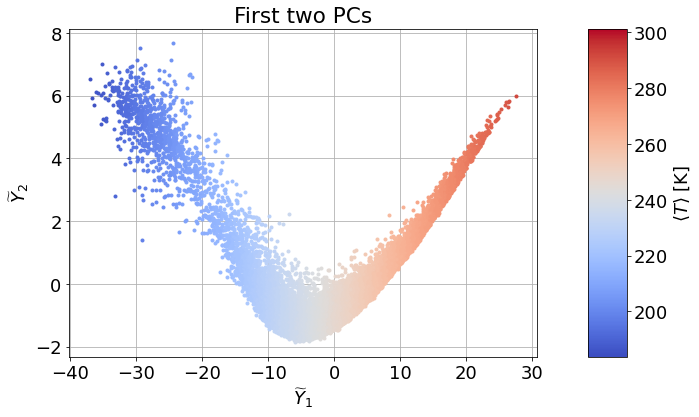

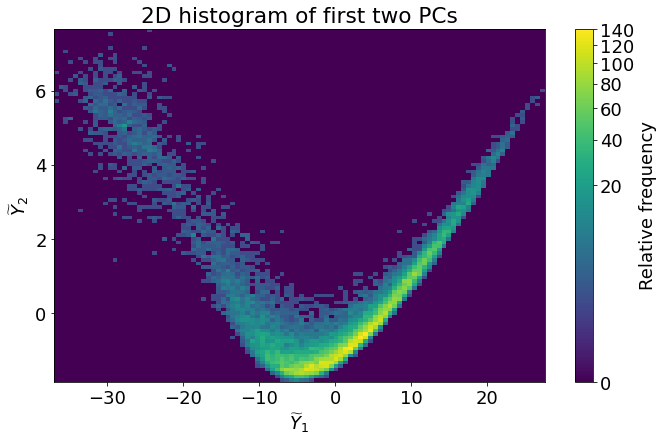

In [72]:
fig, ax = plt.subplots(1,2,figsize=(10,12),gridspec_kw={'width_ratios': [12, 1]})
ncolors = 100
colors = plt.cm.coolwarm(np.linspace(0.,1,ncolors))
avg_temp_normalized = np.mean(data,axis=1)
max_temp = max(avg_temp_normalized)
min_temp = min(avg_temp_normalized)
percentiles = np.linspace(0,1.1,ncolors)
for i in range(N):
    j = np.where((avg_temp_normalized[i]-min_temp) / (max_temp-min_temp) < percentiles)[0][0]
    ax[0].plot(Y[i,0],Y[i,1],'.-',color=colors[j])
ax[0].set_xlabel("$\widetilde{Y}_1$")
ax[0].set_ylabel("$\widetilde{Y}_2$")
ax[0].grid("on")
ax[0].set_title("First two PCs")

fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=min_temp, vmax=max_temp)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax[1], orientation='vertical', label='$\\langle T\\rangle$ [K]')
plt.show()

import matplotlib.colors as mcolors
plt.figure(figsize=(11,6.5))
h = plt.hist2d(Y[:,0],Y[:,1],bins=100,norm=mcolors.PowerNorm(0.3))
plt.title('2D histogram of first two PCs')
plt.colorbar(h[3], ax=plt.gca(),label="Relative frequency")
plt.xlabel("$\widetilde{Y}_1$")
plt.ylabel("$\widetilde{Y}_2$")
plt.show()

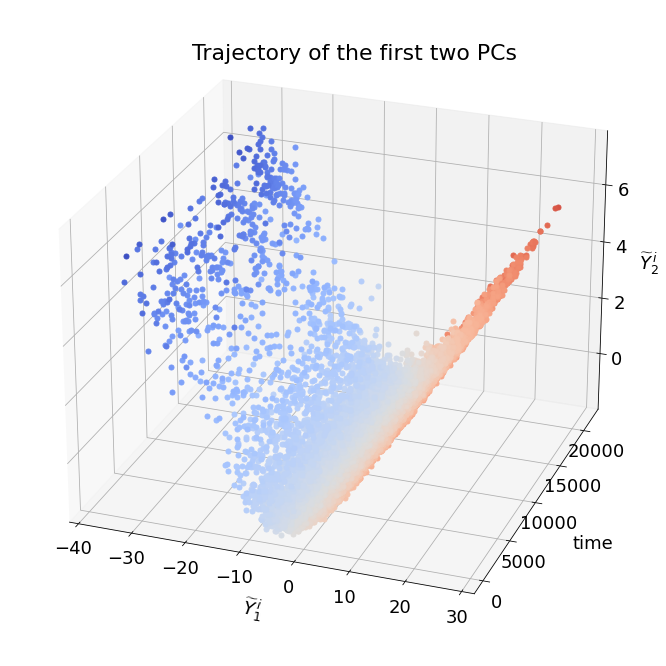

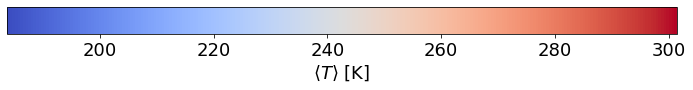

In [33]:
plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
decimated_points = np.linspace(0,N-1,10000,dtype=int)
for i in decimated_points:
    j = np.where((avg_temp_normalized[i]-min_temp) / (max_temp-min_temp) < percentiles)[0][0]
    ax.plot3D(Y[i,0],i,Y[i,1],'.-',color=colors[j],markersize=10)
ax.set_xlabel("$\widetilde{Y}_1^{\,i}$",labelpad=15)
ax.set_ylabel("time",labelpad=25)
ax.set_zlabel("$\widetilde{Y}_2^{\,i}$",labelpad=10)
ax.grid("on")

ax.view_init(25,-70)
ax.zaxis.set_rotate_label(False)
ax.text(-19,0,13.5,"Trajectory of the first two PCs",fontsize=22)

fig, ax2 = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)
cmap = matplotlib.cm.coolwarm
norm = matplotlib.colors.Normalize(vmin=min_temp, vmax=max_temp)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax2, orientation='horizontal', label='$\\langle T\\rangle$ [K]')
plt.show()

## 1) Identification of microstates with k-means++

In [74]:
def k_means(data, k=15, case='standard'):
    N = data.shape[0]
    D = data.shape[1]
    
    # initialize centroids
    if case == 'standard':
        centroids = data[np.random.choice(N ,size=k, replace=False),:]
    elif case == '++':
        centroids = [] 
        centroids.append(data[np.random.choice(N),:]) # pick randomly only first centroid
        k_chosen = 1
        while(k_chosen < k):
            d_x = np.min(euclidean_distances(data,centroids),axis=1)
            probabilities = d_x**2 / np.sum(d_x**2)
            centroids.append(data[np.random.choice(N,p=probabilities)])
            k_chosen += 1
        centroids = np.array(centroids)
    
    # iterative redefinition of centroids
    convergence = np.zeros(k,dtype=bool)
    clusters = {}   
    niterations = 0
    while not np.all(convergence):
        cluster_indices = np.argmin(euclidean_distances(data,centroids),axis=1)
        # update centroids
        for cluster_index in range(k):
            cluster_elements = np.where(cluster_indices==cluster_index)[0]
            new_centroid = np.mean(data[cluster_elements,:],axis=0)
            convergence[cluster_index] = np.array_equal(centroids[cluster_index,:],new_centroid)
            centroids[cluster_index] = new_centroid
        niterations += 1
    
    # compute local minimum of objective function
    objective_func = 0
    clusters = [] 
    distances2_data_centroids = euclidean_distances(data,centroids,squared=True)
    for cluster_index in range(k):
        cluster_elements = np.where(cluster_indices==cluster_index)[0]
        objective_func += sum(distances2_data_centroids[cluster_elements,cluster_index])
        #clusters[cluster_index] = cluster_elements
        clusters.append(cluster_elements.tolist())
    clusters = np.array(clusters,dtype=object)
    
    return clusters, centroids, objective_func, niterations

Fixing number of microstates $k$:

In [75]:
start_time = time.time()

k = 25 # number of microstates, i.e. clusters
ntrials = 100
clusters_trials = {}
centroids_trials = {}
objective_func_trials = []
niterations_trials = []
for i in range(ntrials):
    clusters, centroids, objective_func, niterations = k_means(Y, k=k, case='++')
    clusters_trials[i] = clusters
    centroids_trials[i] = centroids
    objective_func_trials.append(objective_func)
    niterations_trials.append(niterations)
        
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 4.2 minutes


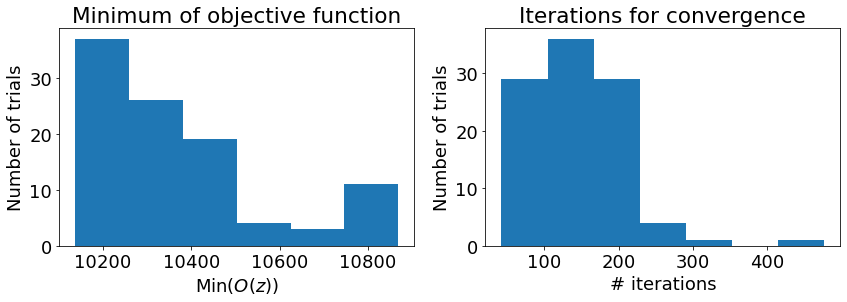

Best convergence achieved in 90 steps to min(O(z)) = 10137.11
Average min(O(z)) reached: < min(O(z)) > = 10374.34
Average number of iterations: 148


In [76]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
ax1.hist(objective_func_trials,bins=6)
ax1.set(title="Minimum of objective function",xlabel="Min($O(z)$)",ylabel="Number of trials")
ax2.hist(niterations_trials,bins=7)
ax2.set(title="Iterations for convergence",xlabel="# iterations",ylabel="Number of trials")
plt.show()

best_trial_index = np.argmin(objective_func_trials)
print("Best convergence achieved in " + str(niterations_trials[best_trial_index]) + 
      " steps to min(O(z)) = {:.2f}".format(objective_func_trials[best_trial_index]))

average_objective_func = np.mean(objective_func_trials)
print("Average min(O(z)) reached: < min(O(z)) > = {:.2f}".format(average_objective_func)) 

average_niterations = int(np.mean(niterations_trials))
print("Average number of iterations: " + str(average_niterations)) 

Ordering clusters according to their 1st Principal Component:

In [77]:
sorted_clusters = np.argsort(centroids_trials[best_trial_index][:,0])
clusters_trials[best_trial_index] = np.array(clusters_trials[best_trial_index])
centroids_trials[best_trial_index] = centroids_trials[best_trial_index][sorted_clusters,:]
clusters_trials[best_trial_index] = clusters_trials[best_trial_index][sorted_clusters][:]

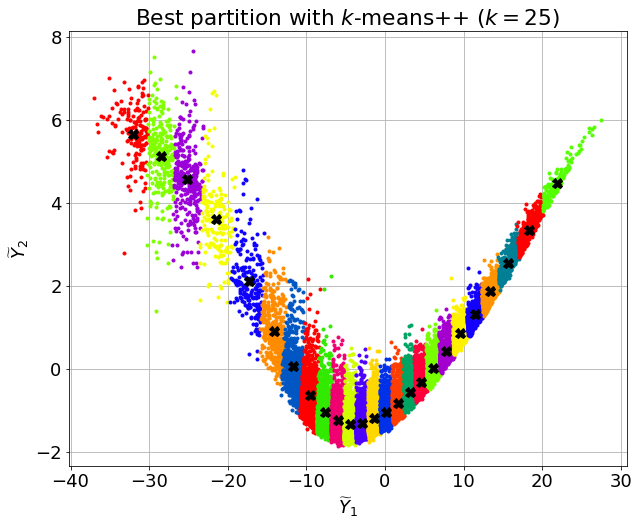

In [81]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,8))
colors = plt.cm.prism(np.linspace(0.,1.,k))
for cluster_index in range(k):
    elements = clusters_trials[best_trial_index][cluster_index]
    plt.plot(Y[elements,0],Y[elements,1],'.',color=colors[cluster_index])
plt.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
plt.xlabel("$\widetilde{Y}_1$")
plt.ylabel("$\widetilde{Y}_2$")
plt.title("Best partition with $k$-means++ ($k = {:d}$)".format(k))
plt.grid("on")
plt.show()

## 2) Estimate of transition matrix 
The transition matrix is defined as
\begin{equation}
    \Pi_{\alpha\beta} = \mathcal{P}\,(\beta,t=\tau|\alpha,t=0)\,,
\end{equation}
where $\alpha,\,\beta$ are cluster labels. The dominant relaxation time should be independent on $\tau$, as can be verified by scanning different values of this hyperparameter.

In [82]:
cluster_traj = np.zeros(N)
for cluster_index in range(k):
    times = clusters_trials[best_trial_index][cluster_index]
    cluster_traj[times] = cluster_index

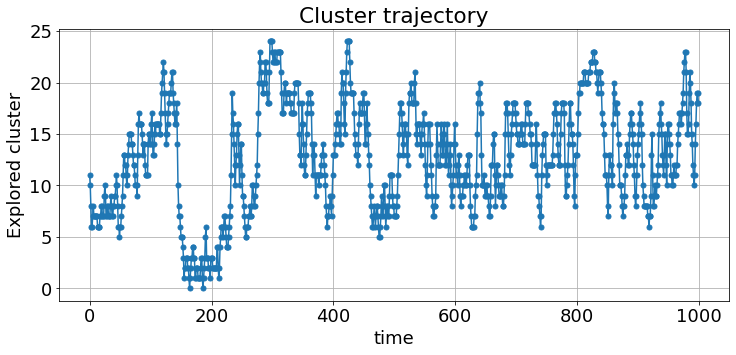

In [83]:
plt.figure(figsize=(12,5))
plt.plot(cluster_traj[:1000],'o-',markersize=5)
plt.xlabel("time")
plt.ylabel("Explored cluster")
plt.title("Cluster trajectory")
plt.grid("on")
plt.show()

The transition matrix in the cluster space can be estimated as:
\begin{equation}
    \Pi_{\alpha\beta} = P(\beta,t+\tau | \alpha,t) \simeq \frac{\text{# pairs }(\alpha,t;\beta,t+\tau)}{\text{# points }(\alpha,t)}
\end{equation}

In [84]:
@numba.njit(fastmath=True)
def compute_transition_matrix(trajectory, k=50, nlags=100):
    N = len(trajectory)
    
    cluster_frequencies = np.zeros(k)
    
    for alpha in range(k):
        cluster_frequencies[alpha] = (np.delete(trajectory,np.arange(N-nlags,N)) == alpha).sum()
    
    transition_matrix = np.zeros((k,k))
    for i in range(N-nlags):
        alpha = int(trajectory[i])
        beta = int(trajectory[i+nlags])
        transition_matrix[alpha,beta] += 1
    
    for alpha in range(k):
        transition_matrix[alpha,:] /= cluster_frequencies[alpha]
            
    return transition_matrix

Computing and diagonalizing the transition matrix for different values of the stride $\tau$:

In [87]:
nlags_trials = np.linspace(1,500,500,dtype=int)
eigenvalues = np.zeros((len(nlags_trials),k),dtype=complex)
for i in range(len(nlags_trials)):
    transition_matrix = compute_transition_matrix(cluster_traj, k=k, nlags=nlags_trials[i])
    eigenvalues[i] = np.linalg.eigvals(transition_matrix)

Plotting the behaviour of the first relaxation time as a function of the stride $\tau$, namely
\begin{equation}
    \tau_1 = -\frac{\tau}{\log\left|\lambda_1 \right|}\,,
\end{equation}
where $\lambda_1$ is the second largest eigenvalue after $\lambda_0  = 1$.

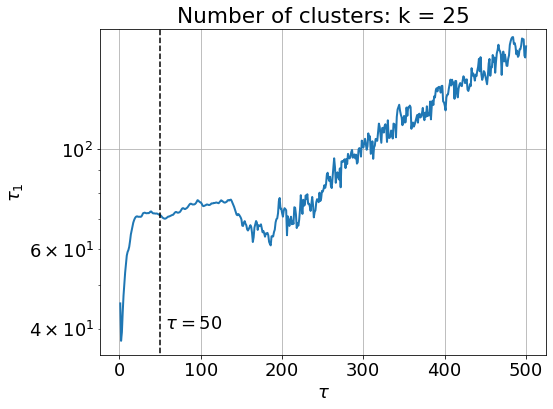

In [88]:
plt.figure(figsize=(8,6))
plt.plot(nlags_trials,-nlags_trials/np.log(np.abs(eigenvalues[:,1])),linewidth=2)
plt.plot(50*np.ones(2),np.linspace(30,185,2),'k--')
plt.text(50,40," $\\tau = 50$")
plt.grid("on")
plt.yscale("log")
plt.xlabel("$\\tau$")
plt.ylabel("$\\tau_1$")
plt.title("Number of clusters: k = " + str(k))
plt.ylim([35,185])
plt.show()

In [90]:
nlags = 50
transition_matrix = compute_transition_matrix(cluster_traj, k=k, nlags=nlags)
eigenvalues, left_eigenvectors, right_eigenvectors = scipy.linalg.eig(transition_matrix,left=True)

# order eigenvalues and eigenvectors in ascending order (in terms of absolute value)
sorted_indices = np.flip(np.argsort(np.abs(eigenvalues)))
eigenvalues = eigenvalues[sorted_indices]
left_eigenvectors = left_eigenvectors[:,sorted_indices]
right_eigenvectors = right_eigenvectors[:,sorted_indices]

sign_u0 = np.sign(np.real(right_eigenvectors[0,0]))
sign_u1 = np.sign(np.real(np.sum(right_eigenvectors[:,1])))

if sign_u0*left_eigenvectors[0,0] < 0: left_eigenvectors *= -1

Verify that transition matrix is normalized along the raws and that sum of left eigenvectors components is zero:

In [91]:
with np.printoptions(precision=2):
    print("Sums along the raws: ", np.sum(transition_matrix,axis=1))
    print("Sums of left eigenvectors components: ", np.sum(np.real(left_eigenvectors[:,1:]),axis=0))

Sums along the raws:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
Sums of left eigenvectors components:  [-2.31e-15 -4.16e-16 -4.16e-16  5.46e-16 -1.46e-16 -1.46e-16  6.71e-16
  6.71e-16  1.12e-15 -3.89e-16  1.53e-16  1.53e-16  4.86e-17  4.86e-17
 -1.18e-16 -1.18e-16 -7.63e-17 -7.63e-17  3.64e-17  3.64e-17  1.39e-16
  1.39e-16 -1.67e-16  6.25e-17]


## 3) Analysis of the spectrum of $\mathbf{\Pi}$ and identification of the Markov states

Plotting the spectrum of the transition matrix to identify the number of relevant relaxation times:

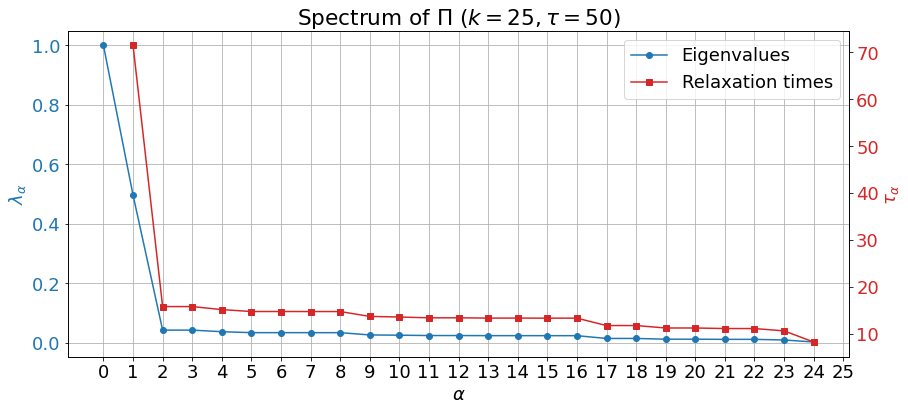

In [92]:
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
lns1 = ax1.plot(np.abs(eigenvalues),'o-',color=color,label="Eigenvalues")
#ax1.set_yscale("log")
ax1.set_ylabel("$\\lambda_{\\alpha}$",color=color)
ax1.set_xlabel("$\\alpha$")
ax1.grid("on")
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:red'
ax2 = ax1.twinx()  
lns2 = ax2.plot(np.arange(1,k),-nlags/np.log(np.abs(eigenvalues[1:])),'s-',color=color,label="Relaxation times")
ax2.set_ylabel("$\\tau_{\\alpha}$",color=color)
#ax2.set_yscale("log")
ax2.tick_params(axis='y', labelcolor=color)
ax1.legend()

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')

plt.title("Spectrum of $\Pi$ ($ k = {:d}, \\tau={:d}$)".format(k,nlags))
plt.xticks(np.arange(0,k+1))
plt.show()


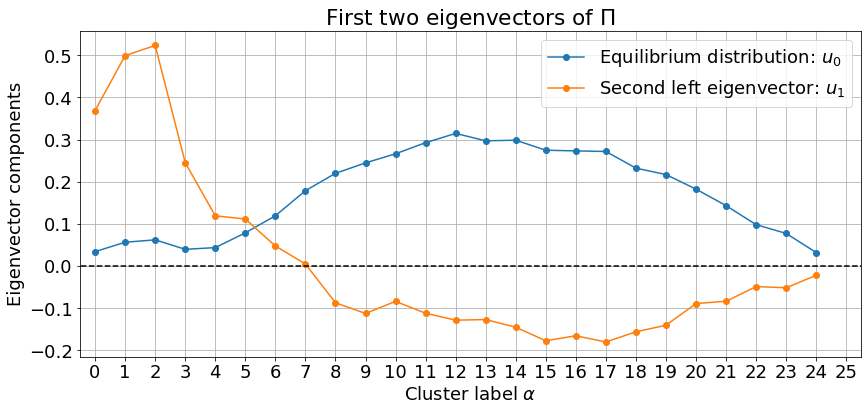

In [269]:
plt.figure(figsize=(14,6))
plt.plot(np.real(sign_u0*left_eigenvectors[:,0]),'o-',label='Equilibrium distribution: $u_0$')
plt.plot(np.real(sign_u1*left_eigenvectors[:,1]),'o-',label='Second left eigenvector: $u_1$')
plt.plot(np.linspace(-1,26,2),np.zeros(2),'k--')
plt.xlabel("Cluster label $\\alpha$")
plt.ylabel("Eigenvector components")
plt.legend(loc='best')
plt.grid("on")
plt.xlim([-0.5,25.5])
plt.xticks(np.arange(0,k+1))
plt.title("First two eigenvectors of $\Pi$")
plt.show()

Identifying Markov States according to ths sign of the components of $u_1$:

In [270]:
markov_states = np.real(sign_u1*left_eigenvectors[:,1]) < 0 

## 4) Visualization of the Markov states in the space of the first two PCs

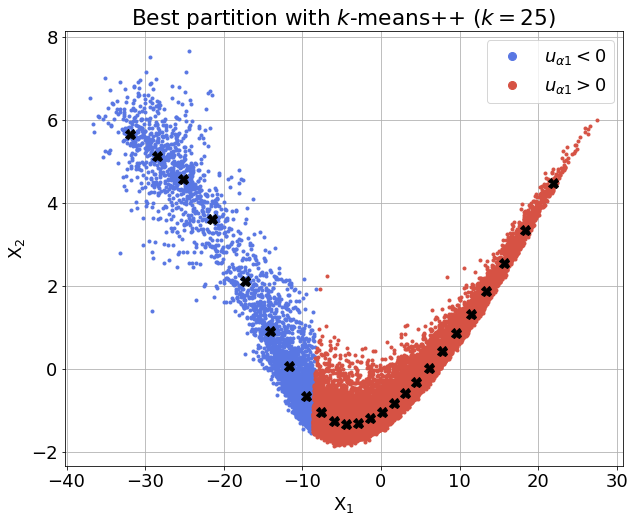

In [271]:
plt.rcParams['font.size'] = 18
plt.figure(figsize=(10,8))
colors = plt.cm.coolwarm(np.linspace(0.1,0.9,2))
labels = ["$u_{\\alpha 1}>0$","$u_{\\alpha 1}<0$"]
for cluster_index in range(k):
    new_index = int(np.where(sorted_indices==cluster_index)[0])
    elements = clusters_trials[best_trial_index][new_index]
    plt.plot(Y[elements,0],Y[elements,1],'.',color=colors[int(markov_states[cluster_index])])#,label = labels[int(markov_states[cluster_index])])
plt.plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kX',markersize=10)
plt.xlabel("X$_1$")
plt.ylabel("X$_2$")
plt.title("Best partition with $k$-means++ ($k = {:d}$)".format(k))
plt.grid("on")
legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='$u_{\\alpha 1} < 0$', markersize=8,lw=0),
                   Line2D([0], [0], marker='o', color=colors[1], label='$u_{\\alpha 1} > 0$', markersize=8,lw=0)]
plt.legend(handles=legend_elements, loc='best')
plt.show()

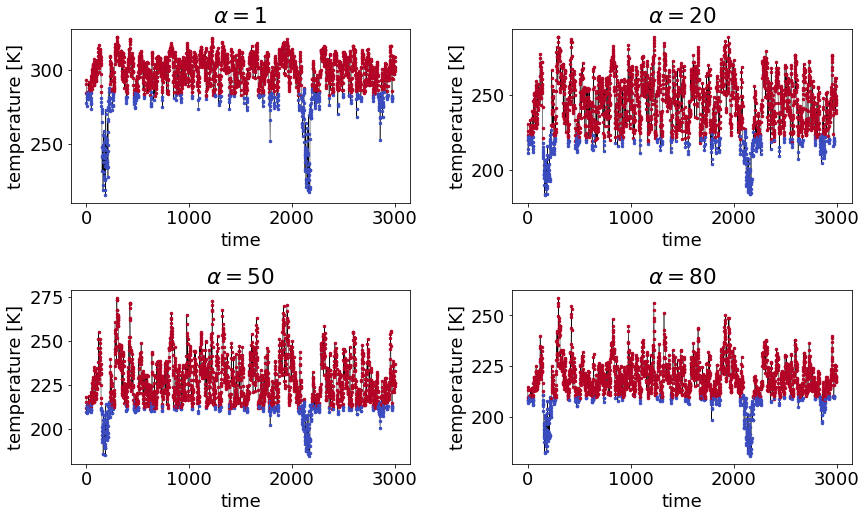

In [179]:
plt.rcParams['font.size'] = 18
sample_variables = np.array([[1,20],[50,80]])
fig, ax = plt.subplots(2,2,figsize=(14,8))
colors = plt.cm.coolwarm(np.linspace(0.1,0.9,2))
length_traj = 3000
for i in range(sample_variables.shape[0]):
    for j in range(sample_variables.shape[1]):
        var = sample_variables[i,j]
        ax[i,j].plot(data[:length_traj,var],'k-',linewidth=0.5)
        for tstep in range(length_traj):
            cluster_index = int(cluster_traj[tstep])
            ax[i,j].plot(tstep,data[tstep,var],'o',color=colors[int(markov_states[cluster_index])],markersize=2.5)
        ax[i,j].set_title("$\\alpha=$" + str(var))
        ax[i,j].set_xlabel("time")
        ax[i,j].set_ylabel("temperature [K]")
fig.subplots_adjust(hspace=.5,wspace=.3)
plt.show()

## 5.1) Stability of the results with respect to variations of $\tau$ at fixed $k=25$

In [94]:
nlags_trials = np.linspace(1,500,500,dtype=int)
eigenvalues = np.zeros((len(nlags_trials),k),dtype=complex)
for i in range(len(nlags_trials)):
    transition_matrix = compute_transition_matrix(cluster_traj, k=k, nlags=nlags_trials[i])
    eigenvalues[i] = np.linalg.eigvals(transition_matrix)

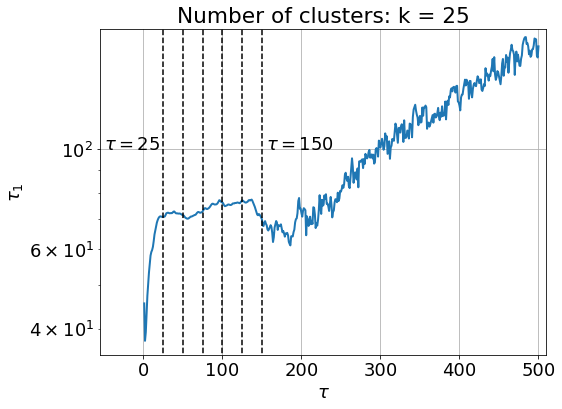

In [120]:
nlags_values = [25,50,75,100,125,150]

plt.figure(figsize=(8,6))
plt.plot(nlags_trials,-nlags_trials/np.log(np.abs(eigenvalues[:,1])),linewidth=2)
for nlags in nlags_values:
    plt.plot(nlags*np.ones(2),np.linspace(30,185,2),'k--')
plt.text(nlags_values[0]-75,100,"$\\tau = $" + str(nlags_values[0]))
plt.text(nlags_values[-1]+5,100,"$\\tau = $" + str(nlags_values[-1]))
plt.grid("on")
plt.yscale("log")
plt.xlabel("$\\tau$")
plt.ylabel("$\\tau_1$")
plt.title("Number of clusters: k = " + str(k))
plt.xlim(-55,510)
plt.ylim([35,185])
plt.show()

In [123]:
eigenvalues = {}
left_eigenvectors = {}
right_eigenvectors = {}
sorted_indices = {}
sign_u0 = {}
sign_u1 = {}

for nlags in nlags_values:
    transition_matrix = compute_transition_matrix(cluster_traj, k=k, nlags=nlags)
    eigenvalues[nlags], left_eigenvectors[nlags], right_eigenvectors[nlags] = scipy.linalg.eig(transition_matrix,left=True)

    # order eigenvalues and eigenvectors in ascending order (in terms of absolute value)
    sorted_indices[nlags] = np.flip(np.argsort(np.abs(eigenvalues[nlags])))
    eigenvalues[nlags] = eigenvalues[nlags][sorted_indices[nlags]]
    left_eigenvectors[nlags] = left_eigenvectors[nlags][:,sorted_indices[nlags]]
    right_eigenvectors[nlags] = right_eigenvectors[nlags][:,sorted_indices[nlags]]

    sign_u0[nlags] = np.sign(np.real(right_eigenvectors[nlags][0,0]))
    sign_u1[nlags] = np.sign(np.real(np.sum(right_eigenvectors[nlags][:,1])))

    if sign_u0[nlags]*left_eigenvectors[nlags][0,0] < 0: left_eigenvectors[nlags] *= -1

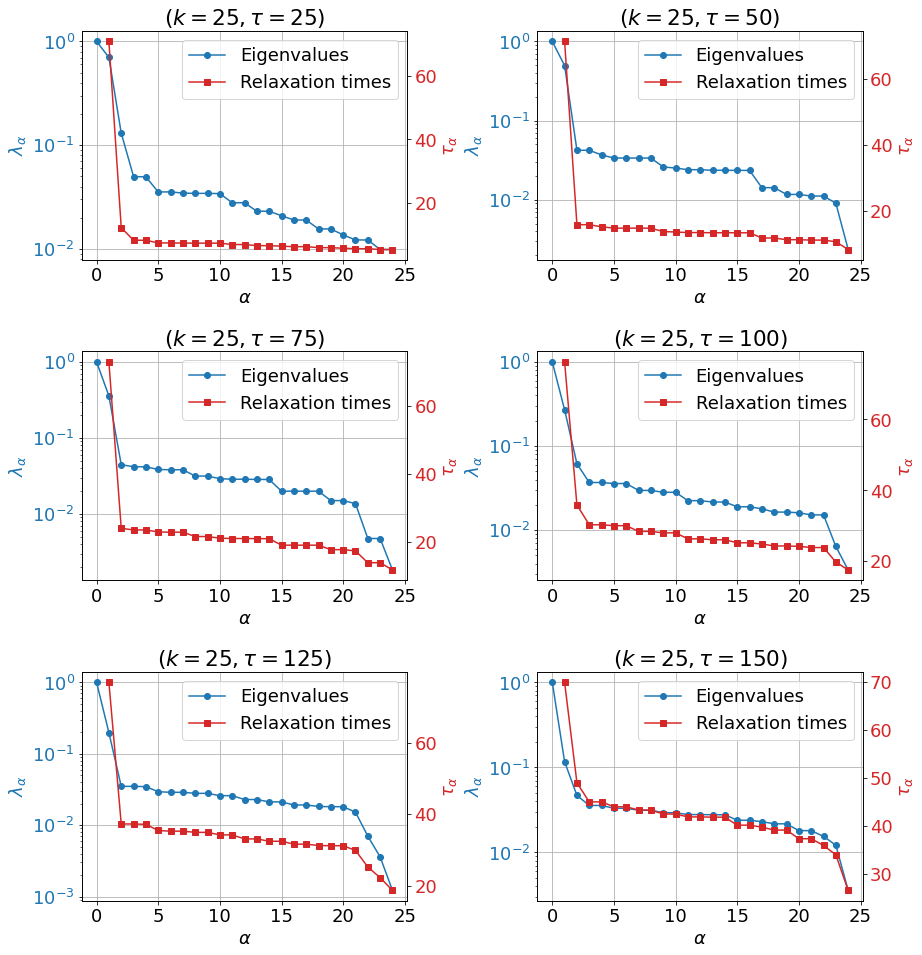

In [125]:
fig, ax1 = plt.subplots(3,2,figsize=(14,16))

index_nlags = 0
for i in range(3):
    for j in range(2):
        nlags = nlags_values[index_nlags]
        index_nlags += 1
        color = 'tab:blue'
        lns1 = ax1[i,j].plot(np.abs(eigenvalues[nlags]),'o-',color=color,label="Eigenvalues")
        ax1[i,j].set_yscale("log")
        ax1[i,j].set_ylabel("$\\lambda_{\\alpha}$",color=color)
        ax1[i,j].set_xlabel("$\\alpha$")
        ax1[i,j].grid("on")
        ax1[i,j].tick_params(axis='y', labelcolor=color)

        color = 'tab:red'
        ax2 = ax1[i,j].twinx()  
        lns2 = ax2.plot(np.arange(1,k),-nlags/np.log(np.abs(eigenvalues[nlags][1:])),'s-',color=color,label="Relaxation times")
        ax2.set_ylabel("$\\tau_{\\alpha}$",color=color)
        #ax2.set_yscale("log")
        ax2.tick_params(axis='y', labelcolor=color)
        #ax1.legend()

        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax1[i,j].legend(lns, labs, loc='best')

        plt.title("($ k = {:d}, \\tau={:d}$)".format(k,nlags))
        #plt.xticks(np.arange(0,k+1))
fig.subplots_adjust(hspace=.4,wspace=.4)
plt.show()

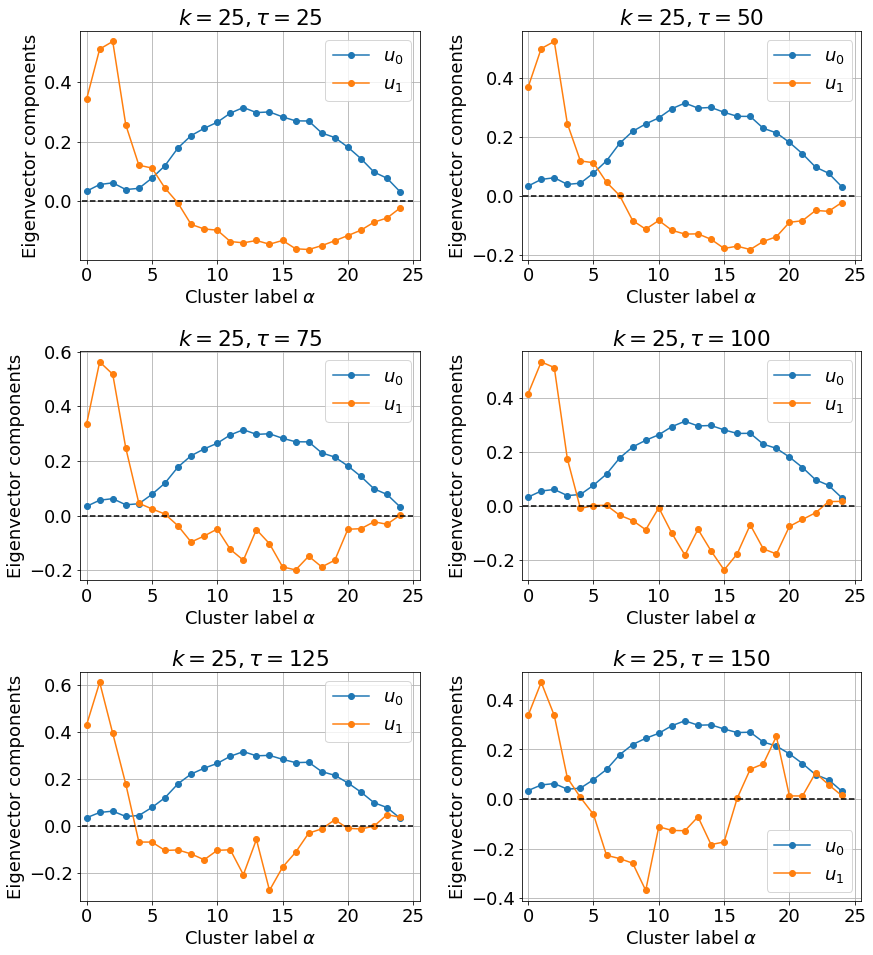

In [129]:
fig, ax = plt.subplots(3,2,figsize=(14,16))

index_nlags = 0
for i in range(3):
    for j in range(2):
        nlags = nlags_values[index_nlags]
        index_nlags += 1
        ax[i,j].plot(np.real(sign_u0[nlags]*left_eigenvectors[nlags][:,0]),'o-',label='$u_0$')
        ax[i,j].plot(np.real(sign_u1[nlags]*left_eigenvectors[nlags][:,1]),'o-',label='$u_1$')
        ax[i,j].plot(np.linspace(-1,k,2),np.zeros(2),'k--')
        ax[i,j].set_xlabel("Cluster label $\\alpha$")
        ax[i,j].set_ylabel("Eigenvector components")
        ax[i,j].legend(loc='best')
        ax[i,j].grid("on")
        ax[i,j].set_xlim([-0.5,k+0.5])
        ax[i,j].set_title("$k = {:d}, \\tau={:d}$".format(k,nlags))
fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

In [130]:
markov_states = {}
for nlags in nlags_values:
    markov_states[nlags] = np.real(sign_u1[nlags]*left_eigenvectors[nlags][:,1]) < 0 

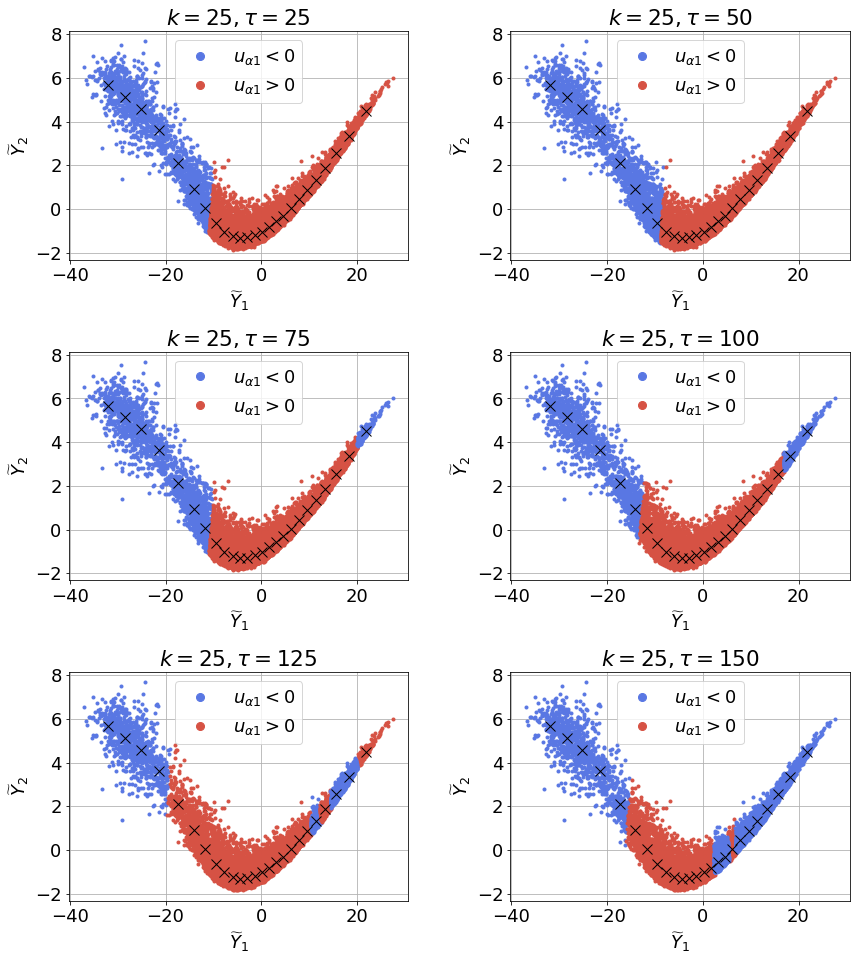

In [132]:
fig, ax = plt.subplots(3,2,figsize=(14,16))
from matplotlib.lines import Line2D
colors = plt.cm.coolwarm(np.linspace(0.1,0.9,2))
index_nlags = 0
labels = ["$u_{\\alpha 1}>0$","$u_{\\alpha 1}<0$"]
for i in range(3):
    for j in range(2):
        nlags = nlags_values[index_nlags]
        index_nlags += 1
        labels = ["$u_{\\alpha 1}>0$","$u_{\\alpha 1}<0$"]
        for cluster_index in range(k):
            new_index = int(np.where(sorted_indices[nlags]==cluster_index)[0])
            elements = clusters_trials[best_trial_index][new_index]
            ax[i,j].plot(Y[elements,0],Y[elements,1],'.',color=colors[int(markov_states[nlags][cluster_index])])
        ax[i,j].plot(centroids_trials[best_trial_index][:,0],centroids_trials[best_trial_index][:,1],'kx',markersize=10)
        ax[i,j].set_xlabel("$\widetilde{Y}_1$")
        ax[i,j].set_ylabel("$\widetilde{Y}_2$")
        ax[i,j].set_title("$k = {:d}, \\tau={:d}$".format(k,nlags))
        ax[i,j].grid("on")
        legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='$u_{\\alpha 1} < 0$',
            markersize=8,lw=0),Line2D([0], [0], marker='o', color=colors[1], 
            label='$u_{\\alpha 1} > 0$', markersize=8,lw=0)]
        ax[i,j].legend(handles=legend_elements, loc='best')

fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

## 5.2) Stability of the results with respect to variations of $k$
Let's repeat the previous analysis for 6 different values of k:

In [17]:
k_values = [i*15 for i in range(1,7)]
k_values

[15, 30, 45, 60, 75, 90]

In [18]:
start_time = time.time()

clusters_trials = {}
centroids_trials = {}
best_trial_indices = {}
for k in k_values:
    ntrials = 100
    objective_func_trials = []
    for i in range(ntrials):
        clusters, centroids, objective_func, niterations = k_means(Y, k=k, case='++')
        clusters_trials[k,i] = clusters
        centroids_trials[k,i] = centroids
        objective_func_trials.append(objective_func)
    best_trial_indices[k] = np.argmin(objective_func_trials)
        
print("Execution time: {:.1f} minutes".format((time.time() - start_time)/60))

Execution time: 12.4 minutes


In [19]:
for k in k_values:
    best_trial_index = best_trial_indices[k]
    sorted_clusters = np.argsort(centroids_trials[k,best_trial_index][:,0])
    
    clusters_trials[k,best_trial_index] = np.array(clusters_trials[k,best_trial_index])
    centroids_trials[k,best_trial_index] = centroids_trials[k,best_trial_index][sorted_clusters,:]
    clusters_trials[k,best_trial_index] = clusters_trials[k,best_trial_index][sorted_clusters][:]

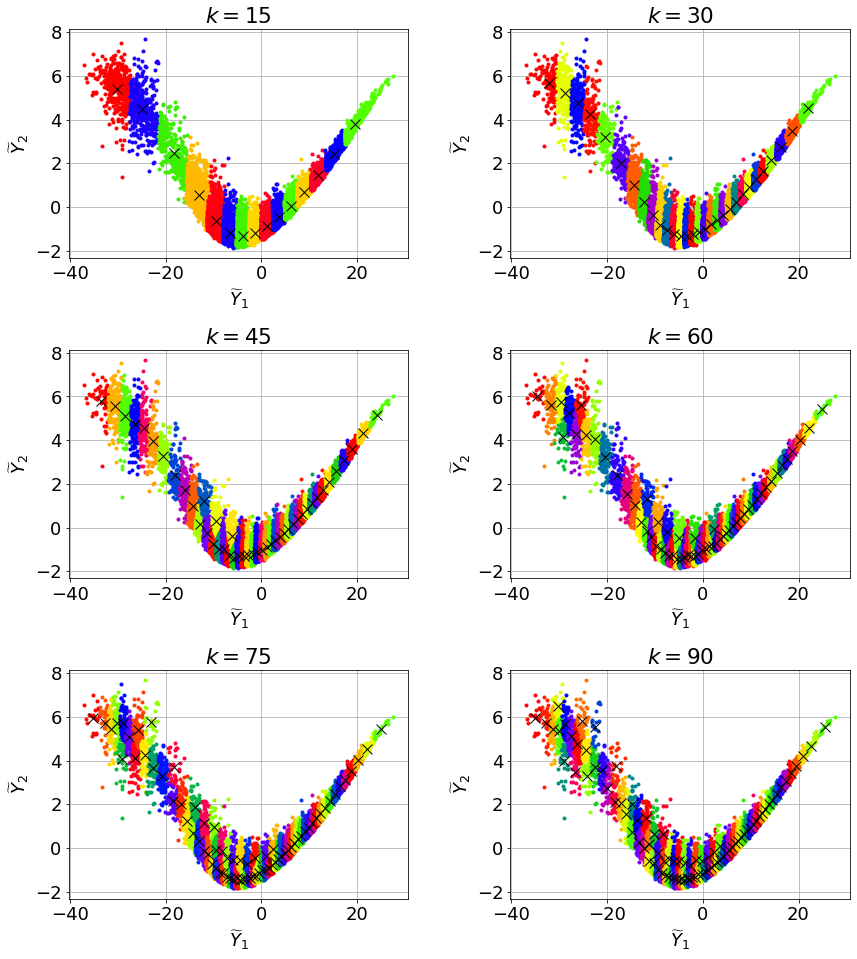

In [20]:
fig, ax = plt.subplots(3,2,figsize=(14,16))
index_kvalues = 0
for i in range(3):
    for j in range(2):
        k = k_values[index_kvalues]
        index_kvalues += 1
        best_trial_index = best_trial_indices[k]
        colors = plt.cm.prism(np.linspace(0.,1.,k))
        for cluster_index in range(k):
            elements = clusters_trials[k,best_trial_index][cluster_index]
            ax[i,j].plot(Y[elements,0],Y[elements,1],'.',color=colors[cluster_index])
        ax[i,j].plot(centroids_trials[k,best_trial_index][:,0],centroids_trials[k,best_trial_index][:,1],'kx',markersize=10)
        ax[i,j].set_xlabel("$\widetilde{Y}_1$")
        ax[i,j].set_ylabel("$\widetilde{Y}_2$")
        ax[i,j].set_title("$k = {:d}$".format(k))
        ax[i,j].grid("on")
fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

In [93]:
cluster_trajs = {}
for k in k_values:
    cluster_trajs[k] = np.zeros(N)
    for cluster_index in range(k):
        best_trial_index = best_trial_indices[k]
        times = clusters_trials[k,best_trial_index][cluster_index]
        cluster_trajs[k][times] = cluster_index

In [151]:
nlags_trials = np.linspace(1,500,500,dtype=int)

eigenvalues = {}
for k in k_values:
    eigenvalues[k] = np.zeros((len(nlags_trials),k),dtype=complex)
    for i in range(len(nlags_trials)):
        transition_matrix = compute_transition_matrix(cluster_trajs[k], k=k, nlags=nlags_trials[i])
        eigenvalues[k][i], eigenvectors = np.linalg.eig(transition_matrix)
        sorted_indices = np.flip(np.argsort(np.abs(eigenvalues[k][i])))
        eigenvalues[k][i,:] = eigenvalues[k][i,sorted_indices]

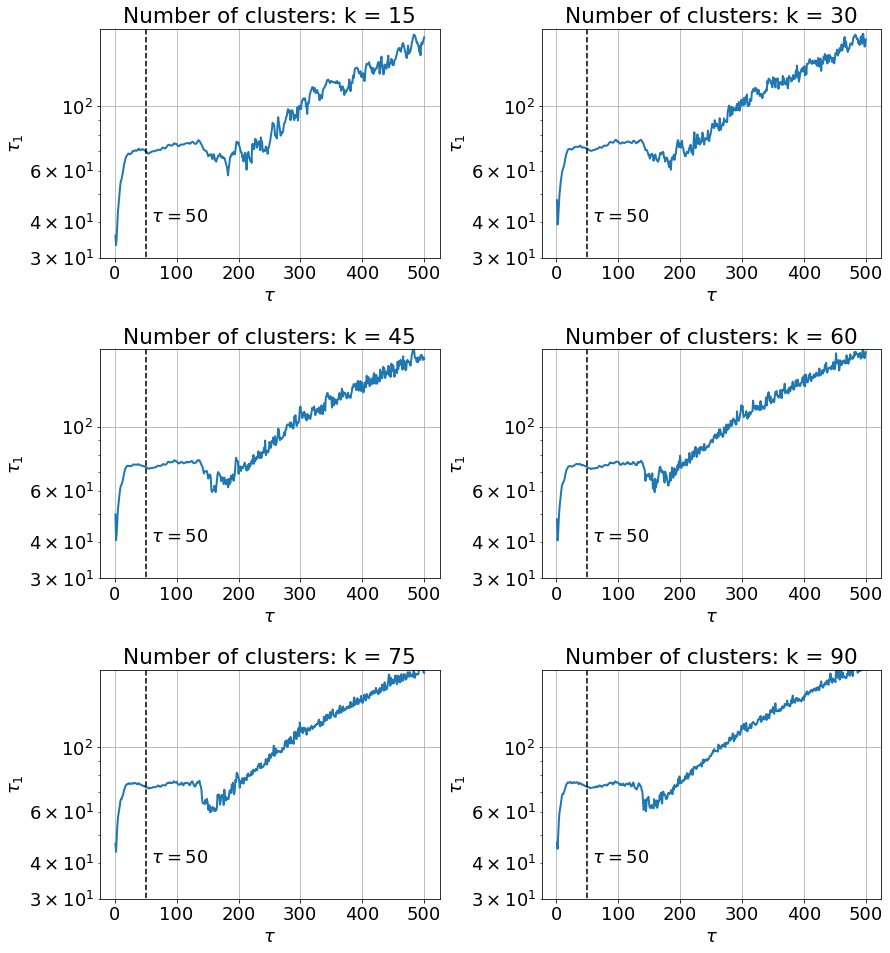

In [108]:
fig, ax = plt.subplots(3,2,figsize=(14,16))
index_kvalues = 0
for i in range(3):
    for j in range(2):
        k = k_values[index_kvalues]
        index_kvalues += 1
        ax[i,j].plot(nlags_trials,-nlags_trials/np.log(np.abs(eigenvalues[k][:,1])),linewidth=2)
        ax[i,j].plot(50*np.ones(2),np.linspace(25,185,2),'k--')
        ax[i,j].text(50,40," $\\tau = 50$")
        ax[i,j].grid("on")
        ax[i,j].set_yscale("log")
        ax[i,j].set_xlabel("$\\tau$")
        ax[i,j].set_ylabel("$\\tau_1$")
        ax[i,j].set_title("Number of clusters: k = " + str(k))
        ax[i,j].set_ylim([30,185])
fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

In [232]:
nlags = 50
eigenvalues = {}
left_eigenvectors = {}
right_eigenvectors = {}
sorted_indices = {}
signs_u0 = {}
signs_u1 = {}
for k in k_values:
    transition_matrix = compute_transition_matrix(cluster_trajs[k], k=k, nlags=nlags)
    eigenvalues[k], left_eigenvectors[k], right_eigenvectors[k] = scipy.linalg.eig(transition_matrix, left=True)
    
    # order eigenvalues and eigenvectors in ascending order (in terms of absolute value)
    sorted_indices[k] = np.flip(np.argsort(np.abs(eigenvalues[k])))
    eigenvalues[k] = eigenvalues[k][sorted_indices[k]]
    left_eigenvectors[k] = left_eigenvectors[k][:,sorted_indices[k]]
    right_eigenvectors[k] = right_eigenvectors[k][:,sorted_indices[k]]
    
    signs_u0[k] = np.sign(np.real(right_eigenvectors[k][0,0]))
    signs_u1[k] = np.sign(np.real(np.sum(right_eigenvectors[k][:,1])))
    if np.real(signs_u0[k]*left_eigenvectors[k][0,0]) < 0: 
          left_eigenvectors[k] *= -1

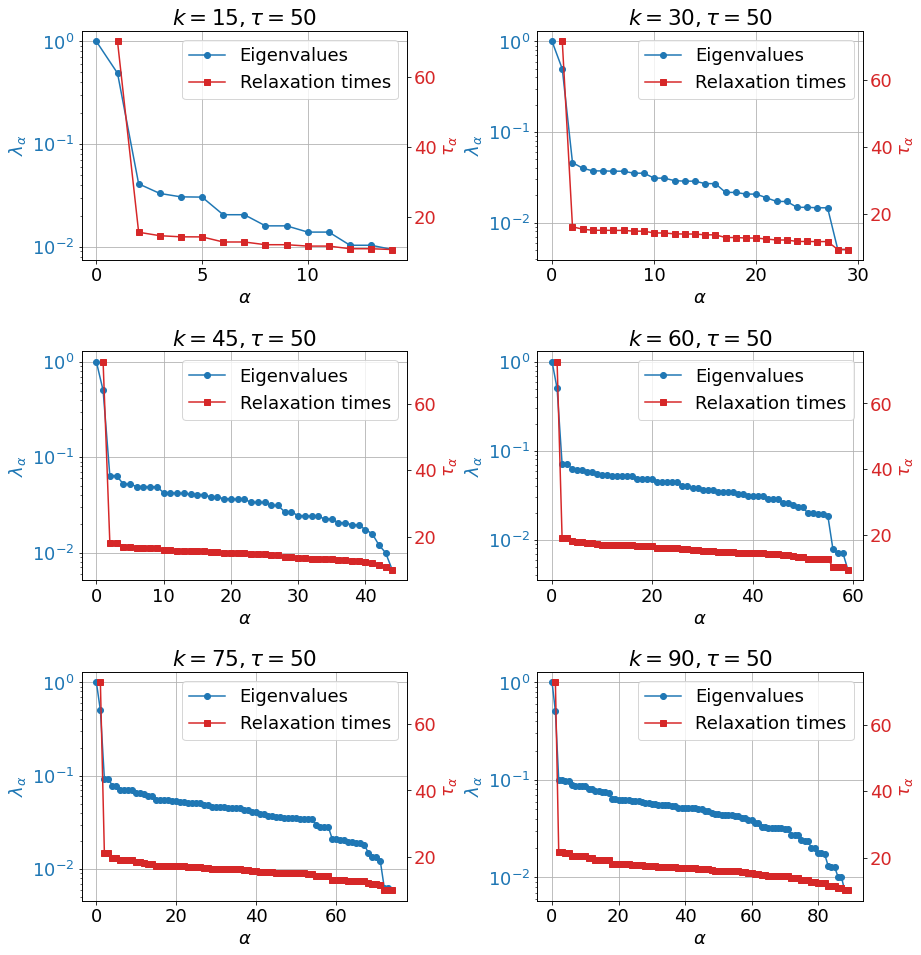

In [140]:
fig, ax1 = plt.subplots(3,2,figsize=(14,16))

index_kvalues = 0
for i in range(3):
    for j in range(2):
        k = k_values[index_kvalues]
        index_kvalues += 1
        color = 'tab:blue'
        lns1 = ax1[i,j].plot(np.abs(eigenvalues[k]),'o-',color=color,label="Eigenvalues")
        ax1[i,j].set_yscale("log")
        ax1[i,j].set_ylabel("$\\lambda_{\\alpha}$",color=color)
        ax1[i,j].set_xlabel("$\\alpha$")
        ax1[i,j].grid("on")
        ax1[i,j].tick_params(axis='y', labelcolor=color)

        color = 'tab:red'
        ax2 = ax1[i,j].twinx()  
        lns2 = ax2.plot(np.arange(1,k),-nlags/np.log(np.abs(eigenvalues[k][1:])),'s-',color=color,label="Relaxation times")
        ax2.set_ylabel("$\\tau_{\\alpha}$",color=color)
        #ax2.set_yscale("log")
        ax2.tick_params(axis='y', labelcolor=color)
        #ax1.legend()

        lns = lns1+lns2
        labs = [l.get_label() for l in lns]
        ax1[i,j].legend(lns, labs, loc='best')

        plt.title("($ k = {:d}, \\tau={:d}$)".format(k,nlags))
        #plt.xticks(np.arange(0,k+1))
fig.subplots_adjust(hspace=.4,wspace=.4)
plt.show()

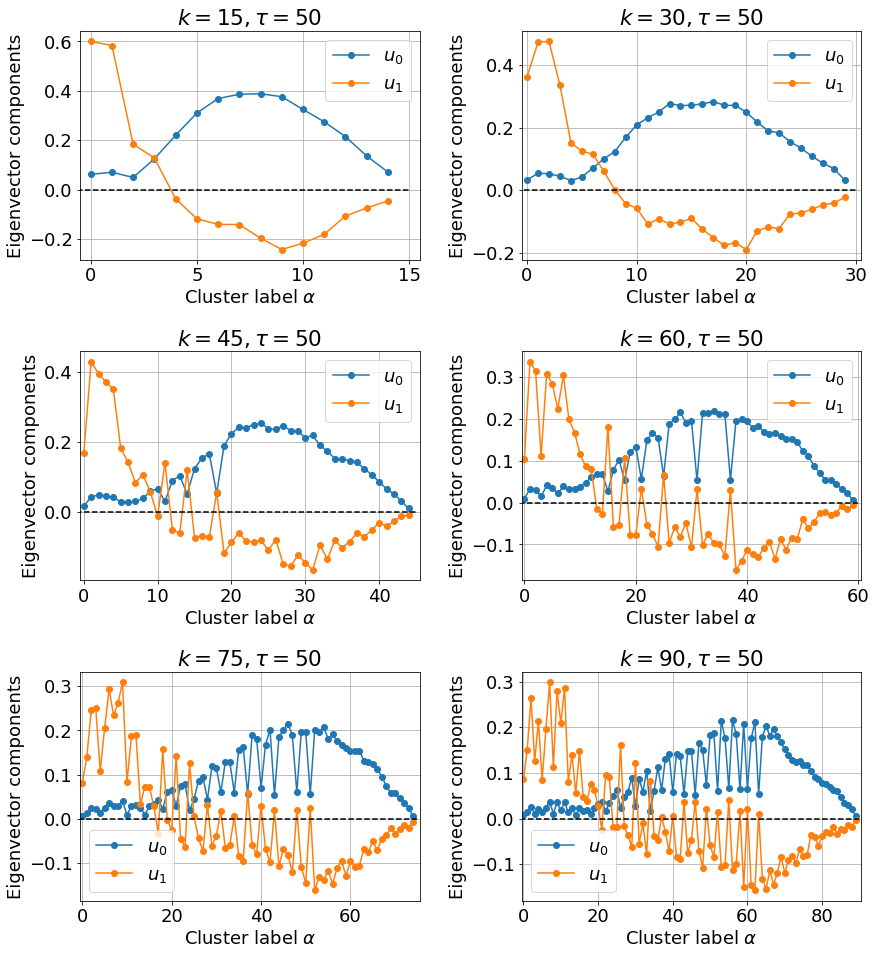

In [233]:
fig, ax = plt.subplots(3,2,figsize=(14,16))

index_kvalues = 0
for i in range(3):
    for j in range(2):
        k = k_values[index_kvalues]
        index_kvalues += 1
        ax[i,j].plot(np.real(signs_u0[k]*left_eigenvectors[k][:,0]),'o-',label='$u_0$')
        ax[i,j].plot(np.real(signs_u1[k]*left_eigenvectors[k][:,1]),'o-',label='$u_1$')
        ax[i,j].plot(np.linspace(-1,k,2),np.zeros(2),'k--')
        ax[i,j].set_xlabel("Cluster label $\\alpha$")
        ax[i,j].set_ylabel("Eigenvector components")
        ax[i,j].legend(loc='best')
        ax[i,j].grid("on")
        ax[i,j].set_xlim([-0.5,k+0.5])
        ax[i,j].set_title("$k = {:d}, \\tau={:d}$".format(k,nlags))
fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

In [241]:
markov_states = {}
for k in k_values:
    markov_states[k] = np.real(signs_u1[k]*left_eigenvectors[k][:,1]) < 0 

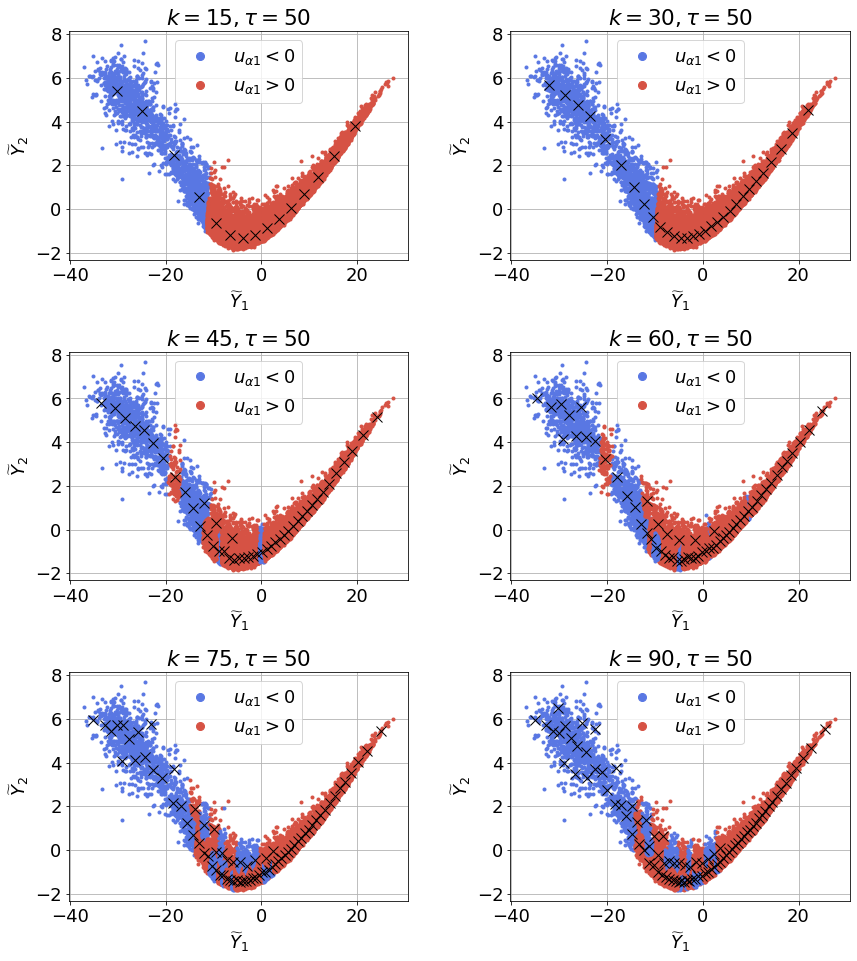

In [247]:
fig, ax = plt.subplots(3,2,figsize=(14,16))
from matplotlib.lines import Line2D
colors = plt.cm.coolwarm(np.linspace(0.1,0.9,2))
index_kvalues = 0
labels = ["$u_{\\alpha 1}>0$","$u_{\\alpha 1}<0$"]
for i in range(3):
    for j in range(2):
        k = k_values[index_kvalues]
        index_kvalues += 1
        labels = ["$u_{\\alpha 1}>0$","$u_{\\alpha 1}<0$"]
        best_trial_index = best_trial_indices[k]
        for cluster_index in range(k):
            new_index = int(np.where(sorted_indices[k]==cluster_index)[0])
            elements = clusters_trials[k,best_trial_index][new_index]
            ax[i,j].plot(Y[elements,0],Y[elements,1],'.',color=colors[int(markov_states[k][cluster_index])])
        ax[i,j].plot(centroids_trials[k,best_trial_index][:,0],centroids_trials[k,best_trial_index][:,1],'kx',markersize=10)
        ax[i,j].set_xlabel("$\widetilde{Y}_1$")
        ax[i,j].set_ylabel("$\widetilde{Y}_2$")
        ax[i,j].set_title("$k = {:d}, \\tau={:d}$".format(k,nlags))
        ax[i,j].grid("on")
        legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='$u_{\\alpha 1} < 0$',
            markersize=8,lw=0),Line2D([0], [0], marker='o', color=colors[1], 
            label='$u_{\\alpha 1} > 0$', markersize=8,lw=0)]
        ax[i,j].legend(handles=legend_elements, loc='best')

fig.subplots_adjust(hspace=.4,wspace=.3)
plt.show()

# 6) Logistic regression that predicts the Markov state from original variables

In [317]:
N = data.shape[0]
nlearning = int(9/10*N)
data_learning = data_std[:nlearning,:]
data_test = data_std[nlearning:,:]

cluster_traj = np.array(cluster_traj,dtype=int)
labels = markov_states[cluster_traj]
labels_learning = labels[:nlearning]
labels_test = labels[nlearning:]

# apply multinomial logistic regression in the learning data set
model = (LogisticRegression(random_state=0, penalty='l2',tol=0.00001,
                            solver='newton-cg',max_iter=1000).fit(data_learning,labels_learning))

# make a prediction based on the logistic model, over training and test sets
labels_predicted_learning = model.predict(data_learning)
labels_predicted_test = model.predict(data_test)

In [318]:
nerrors_learning = np.logical_xor(labels_predicted_learning,labels_learning).sum()
nerrors_test = np.logical_xor(labels_predicted_test,labels_test).sum()
                              
performance_learning = (nlearning-nerrors_learning)/nlearning
performance_test = (N-nlearning-nerrors_test)/(N-nlearning)                        
print("Performance over learning set: {:.3f} %".format(performance_learning*100))
print("Performance over test set: {:.3f} %".format(performance_test*100))

Performance over learning set: 99.985 %
Performance over test set: 99.907 %


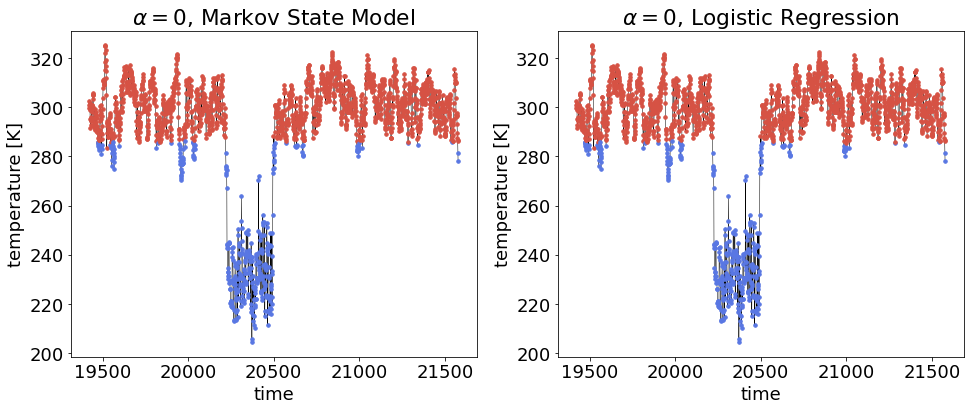

In [335]:
plt.rcParams['font.size'] = 18
sample_variables = np.array([[1,20],[50,80]])
fig, ax = plt.subplots(1,2,figsize=(16,6))
colors = plt.cm.coolwarm(np.linspace(0.1,0.9,2))

var = 0
ax[0].plot(np.arange(nlearning,N),data[nlearning:N,var],'k-',linewidth=0.5)
for tstep in range(nlearning,N):
    cluster_index = int(cluster_traj[tstep])
    ax[0].plot(tstep,data[tstep,var],'o',color=colors[int(labels_test[tstep-nlearning])],markersize=3.5)
ax[0].set_xlabel("time")
ax[0].set_ylabel("temperature [K]")
ax[0].set_title("$\\alpha=$" + str(var) + ", Markov State Model")

ax[1].plot(np.arange(nlearning,N),data[nlearning:N,var],'k-',linewidth=0.5)
for tstep in range(nlearning,N):
    cluster_index = int(cluster_traj[tstep])
    ax[1].plot(tstep,data[tstep,var],'o',color=colors[int(labels_predicted_test[tstep-nlearning])],markersize=3.5)
ax[1].set_xlabel("time")
ax[1].set_ylabel("temperature [K]")
ax[1].set_title("$\\alpha=$" + str(var) + ", Logistic Regression")
fig.subplots_adjust(hspace=.4)
plt.show()